In [3]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math

In [4]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [5]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def concat_sims(path_pref, max_seed):
    df_master = pd.read_csv(f"{path_pref}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    return df_master
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    #tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
    tmp["delta"] = tmp.groupby(["species"])["protein"].diff(periods=8)
    tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

def get_average_protein_no_delta(path, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    #tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

In [21]:
# simulation parameters 
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = [10]
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 100000.0
ribosome_binding_rates_ = [100000.0, 250000.0, 500000.0, 750000.0, 1000000.0, 2500000.0]
ribosome_binding_rates = [5000000.0, 7500000.0, 10000000.0, 25000000.0]
trna_charging_rate = 100.0 
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.9, 0.1)]
ecol_mrna_composition = (0.7, 0.3) # Making e. coli codon usage less optimal
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 0.5
ribosome_footprint = 15

date = "jan-19-2024"

In [146]:
!mkdir ../output/jan-19-2024
!mkdir ../yaml/jan-19-2024

In [183]:
for trna_prop in trna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol_mrna_composition, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [185]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for copy_number in gfp_transcript_copy_number:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [22]:
ribosome_binding_rates = ribosome_binding_rates + ribosome_binding_rates_

df_master = None

for copy_number in gfp_transcript_copy_number:
    df_copy = None
    for binding_rate in ribosome_binding_rates:
        df_binding = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_0.7_0.3_{codons[0]}_{codons[1]}_0.9_0.1" + \
                   f"_{cellular_transcript_copy_number}_{copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_{binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 200, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_binding is not None:
                df_binding = df_binding.append(tmp, ignore_index=True)
            else:
                df_binding = tmp
        df_binding["gfp_rbs"] = binding_rate
        if df_copy is not None:
            df_copy = df_copy.append(df_binding, ignore_index=True)
        else:
            df_copy = df_binding
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_861791/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
/tmp/ipykernel_861791/9851282.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master["codon"] = df_master["codon"].div(1).round(1)


In [23]:
df = df_master[(df_master.copy_number == 10)]
df["gfp_rbs_foldx"] = df["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df = df.pivot_table(index=['gfp_rbs_foldx', 'codon'], columns='species', values='protein')

In [24]:
df["TTT_charged"] = df["TTT_charged"] / 1350
df["ATA_charged"] = df["ATA_charged"] / 150
df["free ribosome"] = df["free ribosome"] / 300

In [28]:
df.to_csv("gfp_expression_simulation.csv")

In [26]:
rcParams['figure.figsize'] = [6, 6]

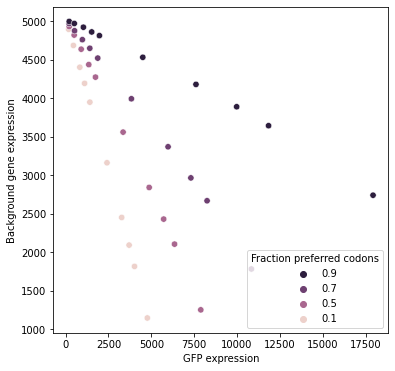

In [27]:
sns.scatterplot(data=df, x = "GFP", y = "cellularProtein", hue = "codon", s=40)
#plt.xscale("log")
plt.xlabel("GFP expression")
plt.ylabel("Background gene expression")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower right")

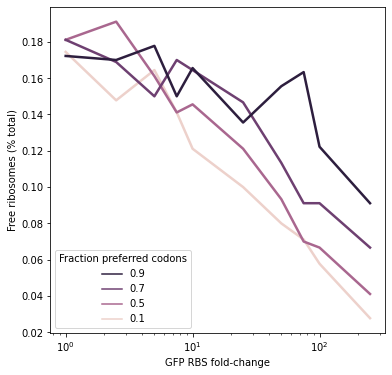

In [12]:
rcParams['figure.figsize'] = [6, 6]
g = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "free ribosome", hue = "codon", linewidth=2.5)
plt.xscale("log")
plt.xlabel("GFP RBS fold-change")
plt.ylabel("Free ribosomes (% total)")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower left")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])

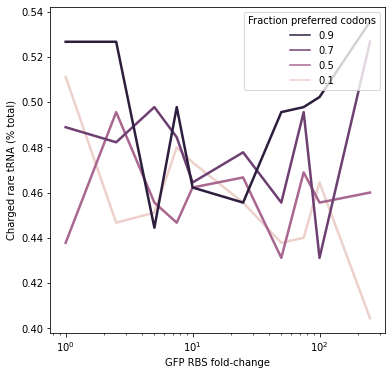

In [19]:
g = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "ATA_charged", hue = "codon", linewidth=2.5)
plt.xscale("log")
plt.xlabel("GFP RBS fold-change")
plt.ylabel("Charged rare tRNA (% total)")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="upper right")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])

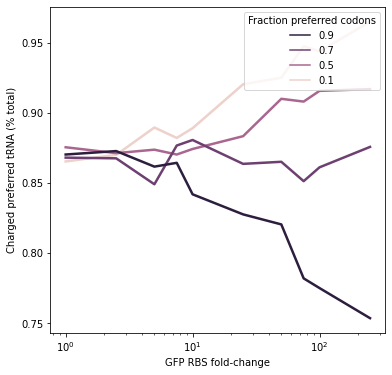

In [20]:
g = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "TTT_charged", hue = "codon", linewidth=2.5)
plt.xscale("log")
plt.xlabel("GFP RBS fold-change")
plt.ylabel("Charged preferred tRNA (% total)")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="upper right")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])

In [14]:
df_ribo = df_master[(df_master.copy_number == 10)]
df_ribo["gfp_rbs_foldx"] = df_ribo["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df_ribo = df_ribo.pivot_table(index=['gfp_rbs_foldx', 'codon'], columns='species', values='ribo_density')

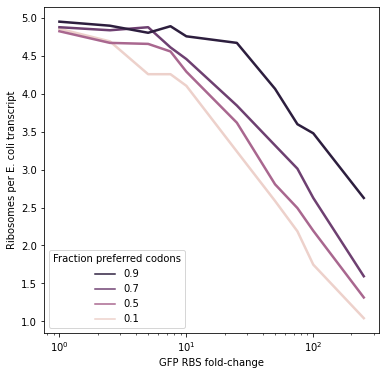

In [16]:
rcParams['figure.figsize'] = [6, 6]
sns.lineplot(data=df_ribo, x = "gfp_rbs_foldx", y = "cellularProtein", hue = "codon", linewidth=2.5)
plt.xscale("log")
plt.xlabel("GFP RBS fold-change")
plt.ylabel("Ribosomes per E. coli transcript")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower left")

### Are we in a regime where codon use has a local optimum?

In [107]:
ecol_mrna_composition = [(x/10, round(1 - (x/10), 2)) for x in range(1, 10)]

In [77]:
# Using the same parameters as jan-19-2024, but turning off GFP binding and 
# simulating ecoli expression for a range of codon compositions
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = [10]
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [0.01]
trna_charging_rate = 100.0 
transcript_names = ["cellularProtein", "GFP"]
trna_composition = (0.9, 0.1)
ecol_mrna_composition = ecol_mrna_composition
gfp_mrna_compositions = [(0.7, 0.3)]
ribosome_speed = 0.5
ribosome_footprint = 15

date = "jan-23-2024"

In [11]:
!mkdir ../output/jan-23-2024
!mkdir ../yaml/jan-23-2024

mkdir: cannot create directory ‘../output/jan-23-2024’: File exists
mkdir: cannot create directory ‘../yaml/jan-23-2024’: File exists


In [42]:
for ecol in ecol_mrna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol, comp],
                                                       trna_proportion=trna_composition,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [43]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for copy_number in gfp_transcript_copy_number:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [87]:
df_master = None
for copy_number in gfp_transcript_copy_number:
    df_copy = None
    for comp in ecol_mrna_composition:
        df_comp = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_{comp[0]}_{comp[1]}_0.7_0.3_0.9_0.1" + \
                   f"_{cellular_transcript_copy_number}_{copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_0.01_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 200, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_comp is not None:
                df_comp = df_comp.append(tmp, ignore_index=True)
            else:
                df_comp = tmp
        df_comp["ecol_comp"] = comp[0]
        if df_copy is not None:
            df_copy = df_copy.append(df_comp, ignore_index=True)
        else:
            df_copy = df_comp
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_2856862/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
/tmp/ipykernel_2856862/1008268399.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master["codon"] = df_master["codon"].div(1).round(1)


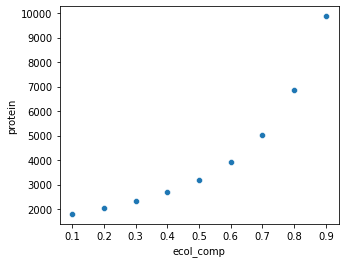

In [89]:
df = df_master[(df_master.species == "cellularProtein")]
g = sns.scatterplot(data=df, x = "ecol_comp", y = "protein")
#plt.xscale("log")
#plt.xlabel("GFP RBS fold-change")
#plt.ylabel("Charged preferred tRNA (% total)")

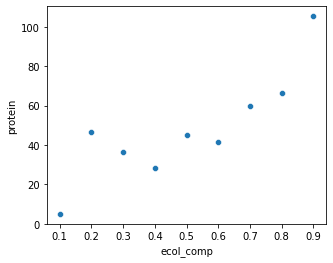

In [90]:
df = df_master[(df_master.species == "free ribosome")]
g = sns.scatterplot(data=df, x = "ecol_comp", y = "protein")

In [53]:
# Scale down the total number of tRNAs
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = [10]
ribosome_copy_number = 300
total_trna = 300 
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [0.01]
trna_charging_rate = 100.0 
transcript_names = ["cellularProtein", "GFP"]
trna_composition = (0.9, 0.1)
ecol_mrna_composition = ecol_mrna_composition
gfp_mrna_compositions = [(0.7, 0.3)]
ribosome_speed = 0.5
ribosome_footprint = 15

date = "jan-23-2024-b"

In [108]:
# also try adding more mRNAs
# more moderate tRNA skew
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = [50, 300]
gfp_transcript_copy_number = 10
ribosome_copy_number = 300
total_trna = 300
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [0.01]
trna_charging_rate = 100.0 
transcript_names = ["cellularProtein", "GFP"]
trna_composition = (0.7, 0.3)
ecol_mrna_composition = ecol_mrna_composition
gfp_mrna_compositions = [(0.7, 0.3)]
ribosome_speed = 0.5
ribosome_footprint = 15

date = "jan-23-2024-c"

In [64]:
for ecol in ecol_mrna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol, comp],
                                                       trna_proportion=trna_composition,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [63]:
!mkdir ../output/jan-23-2024-c
!mkdir ../yaml/jan-23-2024-c

In [66]:
configs = os.listdir(f"../yaml/jan-23-2024")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for copy_number in cellular_transcript_copy_number:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/jan-23-2024/{config} {seed} {copy_number} {gfp_transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [109]:
df_master = None
for copy_number in cellular_transcript_copy_number:
    df_copy = None
    for comp in ecol_mrna_composition:
        df_comp = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_{comp[0]}_{comp[1]}_0.7_0.3_0.9_0.1" + \
                   f"_{copy_number}_{gfp_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_0.01_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 200, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_comp is not None:
                df_comp = df_comp.append(tmp, ignore_index=True)
            else:
                df_comp = tmp
        df_comp["ecol_comp"] = comp[0]
        if df_copy is not None:
            df_copy = df_copy.append(df_comp, ignore_index=True)
        else:
            df_copy = df_comp
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_2856862/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()


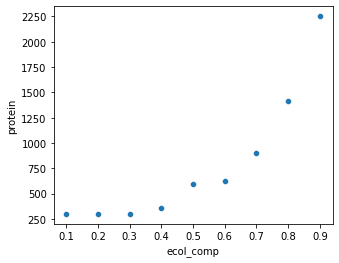

In [115]:
df = df_master[(df_master.species == "cellularProtein")]
df = df[(df.copy_number == 50)]
g = sns.scatterplot(data=df, x = "ecol_comp", y = "protein")

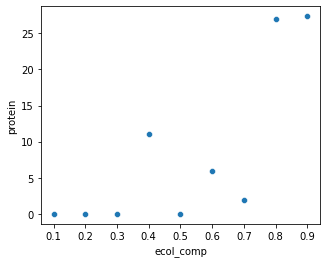

In [114]:
df = df_master[(df_master.species == "free ribosome")]
df = df[(df.copy_number == 50)]
g = sns.scatterplot(data=df, x = "ecol_comp", y = "protein")

In [ ]:
# replicating 
ecol_mrna_composition = [(x/10, round(1 - (x/10), 2)) for x in range(1, 10)]

time_limit = 200
time_step = 5
transcript_lens = [100]
cellular_transcript_copy_number = [100]
gfp_transcript_copy_number = 10
ribosome_copy_number = 100
total_trna = 100
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [0.01]
trna_charging_rate = 100.0 
transcript_names = ["cellularProtein", "GFP"]
trna_composition = (0.7, 0.3)
ecol_mrna_composition = ecol_mrna_composition
gfp_mrna_compositions = [(0.7, 0.3)]
ribosome_speed = 1
ribosome_footprint = 15

date = "jan-23-2024-c"

In [ ]:
# simulation parameters
time_limit = 500
time_step = 5
transcript_len = 100
trna_props = [1, 2, 5, 10, 20, 30, 40, 45, 48, 49, 50, 51, 52, 55, 60, 70, 80, 90, 95, 98, 99]
codon_comps = range(1, 100)
transcript_copy_number = 100
ribosome_copy_number = 100
total_trna = 100
ribosome_binding_rate = 100000.0
trna_charging_rates = [10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]